In [1]:

import numpy as np # linear algebra
import pandas as pd

In [2]:
!pip install imutils

In [3]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours

In [4]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
!unzip -qo data.zip

--2023-10-19 10:09:16--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.160.79, 52.219.160.43, 52.219.160.115, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.160.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28437489 (27M) [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip            100%[===================>]  27.12M  8.99MB/s    in 3.0s    

2023-10-19 10:09:20 (8.99 MB/s) - ‘data.zip’ saved [28437489/28437489]



In [5]:
x = []
y = []
datadir = 'data/dataset'
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)

print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

7600
7600
labels : ['0', 'sub', 'mul', '2', '3', 'div', '8', 'add', '9', '5', '7', '4', '6', '1']


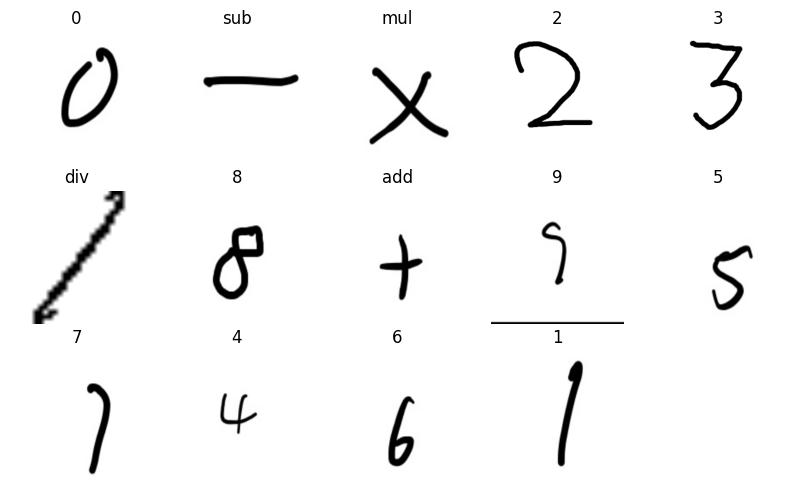

In [6]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

In [7]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

7600


In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

7600


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [12]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [13]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))

    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [14]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                   

In [17]:
aug = ImageDataGenerator(zoom_range=0.1,
#                          rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=10, validation_data=(X_test, Y_test))
# hist2 = model2.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/10
48/48 [==============================] - 5s 108ms/step - loss: 0.5895 - accuracy: 0.8720 - val_loss: 0.7784 - val_accuracy: 0.8414
Epoch 2/10
48/48 [==============================] - 6s 117ms/step - loss: 0.5380 - accuracy: 0.8831 - val_loss: 0.6547 - val_accuracy: 0.8697
Epoch 3/10
48/48 [==============================] - 6s 116ms/step - loss: 0.5074 - accuracy: 0.8877 - val_loss: 0.6973 - val_accuracy: 0.8480
Epoch 4/10
48/48 [==============================] - 6s 116ms/step - loss: 0.4763 - accuracy: 0.8974 - val_loss: 0.6857 - val_accuracy: 0.8605
Epoch 5/10
48/48 [==============================] - 5s 108ms/step - loss: 0.4469 - accuracy: 0.9067 - val_loss: 0.5465 - val_accuracy: 0.8980
Epoch 6/10
48/48 [==============================] - 5s 108ms/step - loss: 0.4009 - accuracy: 0.9163 - val_loss: 0.4627 - val_accuracy: 0.9237
Epoch 7/10
48/48 [==============================] - 5s 109ms/step - loss: 0.3849 - accuracy: 0.9197 - val_loss: 0.6330 - val_accuracy: 0.8697
Epoch 

In [18]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

48/48 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       126
           1       0.98      0.89      0.93       116
           2       0.98      0.96      0.97        92
           3       0.98      0.91      0.94       111
           4       0.94      0.85      0.89       100
           5       0.99      0.89      0.94        83
           6       0.90      0.94      0.92       104
           7       0.93      0.97      0.95        94
           8       0.81      0.95      0.87       118
           9       0.84      0.99      0.91        92
          10       0.97      0.98      0.97       116
          11       1.00      1.00      1.00        97
          12       1.00      0.96      0.98       132
          13       1.00      0.99      1.00       139

    accuracy                           0.94      1520
   macro avg       0.95      0.94      0.94      1520
weighted avg       0.95    